# LogLite: A Lightweight Framework for Real-Time Anomaly Detection and Analysis of System Logs

This notebook implements a lightweight framework for anomaly detection and analysis of system logs using DistilBERT and SHAP for explainability.

## 1. Install Required Packages

In [ ]:
!pip install transformers datasets shap scikit-learn matplotlib wandb

## 2. Import Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import random
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, DistilBertModel
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import shap
import wandb
from collections import Counter
import seaborn as sns

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 3. Initialize WandB (Optional)

You can comment this out if you don't want to use Weights & Biases.

In [ ]:
# Initialize WandB
WANDB_API_KEY = "5679e580c87ce0c7b8868493ca648dcfa350ea84"
wandb.login(key=WANDB_API_KEY)

# Initialize Wandb run
wandb.init(project="LogLite-Final", entity="oxcomrade-noakhali-science-and-technology-university")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


eval/accuracy,█████████████▁▁▁▁▁▁▁▁▁██████
eval/f1,█████▇███████▁▁▁▁▁▁▁▁▁▇█████
eval/loss,▅▃▂▂▂▅▄▃▂▂▁▁▁█████▇▇▇▇▆▄▃▂▁▁
eval/precision,█████▇███████▁▁▁▁▁▁▁▁▁▇█████
eval/recall,█████████████▁▁▁▁▁▁▁▁▁██████
eval/runtime,▄▂▃▁▂▆▃▃▁▁▁▂▁▄▃▃▂█▃▃▃▁▂▁▃▂▃▂
eval/samples_per_second,▄▆▅█▇▂▆▆███▇▇▅▆▆▇▁▆▆▅█▇█▆▇▅▇
eval/steps_per_second,▄▆▅█▇▂▆▆███▇▇▅▆▆▇▁▆▆▅█▇█▆▇▅▇
train/epoch,▁▂▂▂▃▅▅▁▁▂▃▄▄▅▅██▁▂▂▃▃▁▁▂▃▄▄▅▆▆▁▂▂▂▃▄▄▅▆
train/global_step,▁▁▂▄▅▁▁▂▂▃▄▅▅▆▇▇██▁▂▃▃▁▂▂▃▃▄▄▄▆▁▁▂▂▃▄▅▅▆
train/grad_norm,▃▄▄▄▁▃▆▄▆▅▅▁▄█▃▁▄▃▇▃▄▄▄▄▅▅▅▄▅▆▅█▃▅▅▅▂▄▆▁


## 4. Data Loading and Preprocessing Functions

In [ ]:
# Function to parse log lines
def parse_log(line):
    # Extract timestamp, node, and message parts
    try:
        parts = line.strip().split()
        timestamp = parts[0]
        node = parts[1]
        message = ' '.join(parts[2:])

        # Extract label
        if '-' in message:
            label = '-'  # Normal log
        else:
            # Try to extract the label (anomaly type)
            label_match = re.search(r'(APPREAD|KERNDTLB|KERNSTOR|KERNRTSP|KERNTERM|APPSEV|KERNMNTF|APPTO|APPRES|APPOUT|KERNREC)', message)
            if label_match:
                label = label_match.group(1)
            else:
                label = 'UNKNOWN'

        return {
            'timestamp': timestamp,
            'node': node,
            'message': message,
            'label': label
        }
    except Exception as e:
        print(f"Error parsing line: {line}")
        print(f"Exception: {e}")
        return None

# Load and parse the data
def load_data(file_path, max_lines=None):
    logs = []
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f):
            if max_lines and i >= max_lines:
                break

            parsed = parse_log(line)
            if parsed:
                logs.append(parsed)

    return pd.DataFrame(logs)

## 5. Load and Prepare Dataset

Note: You need to upload your BGL dataset to Colab first. Use the file browser on the left sidebar to upload your dataset.

In [ ]:
# For Colab: Upload the BGL dataset
from google.colab import files
uploaded = files.upload()  # Upload your BGL dataset

# After uploading, specify the path
DATA_PATH = list(uploaded.keys())[0]  # This gets the filename of the uploaded file

# Alternatively, if you already know the path, you can set it directly
# DATA_PATH = "BGL.log"  # Update this path if needed

Saving BGL_2k.log_structured.csv to BGL_2k.log_structured (1).csv


In [ ]:
# Set the path to the uploaded CSV file
DATA_PATH = "BGL_2k.log_structured.csv"

# Load the CSV file directly using pandas
df = pd.read_csv(DATA_PATH)

# Display information about the loaded data
print(f"Dataset loaded with {len(df)} entries")
print("\nColumns in the dataset:")
print(df.columns.tolist())

# Check what column contains the labels
# The label column might be named "Label", "EventTemplate", "EventType", etc.
print("\nSample data:")
print(df.head())

# Identify the label column - check the CSV structure
# If there's a column that contains label information, use it
# For example, it might be called "Label" or "EventType"
# Let's assume it's called "Label" - adjust as needed based on your CSV structure
if "Label" in df.columns:
    print("\nLabel distribution:")
    print(df["Label"].value_counts())
    # Use "Label" as your label column
    label_column = "Label"
elif "EventType" in df.columns:
    print("\nEvent Type distribution:")
    print(df["EventType"].value_counts())
    # Use "EventType" as your label column
    label_column = "EventType"
else:
    # List first few columns to help identify the right one
    print("\nCouldn't find standard label column. Here are the first 5 columns:")
    for col in df.columns[:5]:
        print(f"\nUnique values in {col}:")
        print(df[col].value_counts().head())

    # You'll need to manually set the label column
    label_column = "YourLabelColumnName"  # Change this based on inspection

# After identifying the correct label column, use it instead of the hardcoded 'label'
# For example, when creating binary labels:
# df['binary_label'] = df[label_column].apply(lambda x: 0 if x == '-' else 1)

Dataset loaded with 2000 entries

Columns in the dataset:
['LineId', 'Label', 'Timestamp', 'Date', 'Node', 'Time', 'NodeRepeat', 'Type', 'Component', 'Level', 'Content', 'EventId', 'EventTemplate']

Sample data:
   LineId Label   Timestamp        Date                 Node  \
0       1     -  1117838570  2005.06.03  R02-M1-N0-C:J12-U11   
1       2     -  1117838573  2005.06.03  R02-M1-N0-C:J12-U11   
2       3     -  1117838976  2005.06.03  R02-M1-N0-C:J12-U11   
3       4     -  1117838978  2005.06.03  R02-M1-N0-C:J12-U11   
4       5     -  1117842440  2005.06.03  R23-M0-NE-C:J05-U01   

                         Time           NodeRepeat Type Component Level  \
0  2005-06-03-15.42.50.675872  R02-M1-N0-C:J12-U11  RAS    KERNEL  INFO   
1  2005-06-03-15.42.53.276129  R02-M1-N0-C:J12-U11  RAS    KERNEL  INFO   
2  2005-06-03-15.49.36.156884  R02-M1-N0-C:J12-U11  RAS    KERNEL  INFO   
3  2005-06-03-15.49.38.026704  R02-M1-N0-C:J12-U11  RAS    KERNEL  INFO   
4  2005-06-03-16.47.20.73054

## 6. Create Labels and Data Splits

In [ ]:
# Create binary labels (normal vs anomaly)
df['binary_label'] = df['Label'].apply(lambda x: 0 if x == '-' else 1)

# Create a label mapper for multi-class classification
unique_labels = df['Label'].unique()
label_map = {label: idx for idx, label in enumerate(unique_labels)}
df['label_id'] = df['Label'].map(label_map)

print("\nLabel mapping:")
for label, idx in label_map.items():
    print(f"{label} -> {idx}")


Label mapping:
- -> 0
APPREAD -> 1
KERNDTLB -> 2
KERNSTOR -> 3
APPCHILD -> 4
KERNRTSP -> 5
KERNTERM -> 6
APPSEV -> 7
KERNMNTF -> 8
KERNREC -> 9
APPTO -> 10
APPRES -> 11
APPOUT -> 12


In [ ]:
# Find classes with more than 1 sample
label_counts = df['label_id'].value_counts()
print(f"Label counts:\n{label_counts}")

valid_labels = label_counts[label_counts >= 2].index
print(f"Number of valid labels (with ≥ 2 samples): {len(valid_labels)}")

# Filter dataset to include only classes with sufficient samples
filtered_df = df[df['label_id'].isin(valid_labels)]
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(filtered_df)}")

if len(filtered_df) == 0:
    print("WARNING: Filtered dataset is empty! All classes have only 1 sample.")
    # Fall back to option 1 (no stratification)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        df['Content'],
        df['label_id'],
        test_size=0.2,
        random_state=SEED
    )
else:
    # Now use stratification on the filtered dataset
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        filtered_df['Content'],
        filtered_df['label_id'],
        test_size=0.2,
        random_state=SEED,
        stratify=filtered_df['label_id']
    )

# Further split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    random_state=SEED,
    stratify=y_train_val
)

# Make sure to include these print statements
print(f"\nTraining set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Check class distribution
train_counts = pd.Series(y_train).value_counts().sort_index()
val_counts = pd.Series(y_val).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

print("\nClass distribution in training set:")
print(train_counts)
print("\nClass distribution in validation set:")
print(val_counts)
print("\nClass distribution in test set:")
print(test_counts)

Label counts:
label_id
0     1857
2       60
3       30
7       17
8       11
6        7
9        5
11       4
1        3
10       2
5        2
4        1
12       1
Name: count, dtype: int64
Number of valid labels (with ≥ 2 samples): 11
Original dataset size: 2000
Filtered dataset size: 1998

Training set: 1198 samples
Validation set: 400 samples
Test set: 400 samples

Class distribution in training set:
label_id
0     1113
1        2
2       36
3       18
5        2
6        4
7       10
8        7
9        3
10       1
11       2
Name: count, dtype: int64

Class distribution in validation set:
label_id
0     372
2      12
3       6
6       2
7       3
8       2
9       1
10      1
11      1
Name: count, dtype: int64

Class distribution in test set:
label_id
0     372
1       1
2      12
3       6
6       1
7       4
8       2
9       1
11      1
Name: count, dtype: int64


## 7. Tokenization and Dataset Creation

In [ ]:
# Initialize tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Define a max sequence length for balanced efficiency and information
MAX_LENGTH = 128

# Tokenize the data
def tokenize_function(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

# Create datasets
train_encodings = tokenize_function(X_train.tolist())
val_encodings = tokenize_function(X_val.tolist())
test_encodings = tokenize_function(X_test.tolist())

In [ ]:
# Convert to PyTorch dataset
class LogDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = LogDataset(train_encodings, y_train.tolist())
val_dataset = LogDataset(val_encodings, y_val.tolist())
test_dataset = LogDataset(test_encodings, y_test.tolist())

## 8. Calculate Class Weights to Handle Imbalanced Data

In [ ]:
# Calculate class weights to handle imbalanced data (fixed version)
def calculate_class_weights(labels):
    counter = Counter(labels)
    max_count = max(counter.values())
    weights = {label: max_count / count for label, count in counter.items()}

    # Get the number of unique classes
    num_classes = max(counter.keys()) + 1

    # Initialize weights array with 1.0 for all classes
    ordered_weights = [1.0] * num_classes

    # Assign weights only for classes that exist in the dataset
    for label, weight in weights.items():
        ordered_weights[label] = weight

    return torch.tensor(ordered_weights, dtype=torch.float)

# Calculate weights
weights = calculate_class_weights(y_train.tolist())
print("\nClass weights:")
print(weights)


Class weights:
tensor([1.0000e+00, 5.5650e+02, 3.0917e+01, 6.1833e+01, 1.0000e+00, 5.5650e+02,
        2.7825e+02, 1.1130e+02, 1.5900e+02, 3.7100e+02, 1.1130e+03, 5.5650e+02])


## 9. Model Definition (DistilBERT with Class Weights)

In [ ]:
# Create a DistilBERT model with class weights for handling imbalance
class WeightedDistilBert(DistilBertForSequenceClassification):
    def __init__(self, config, class_weights=None, dropout_rate=0.3):
        super().__init__(config)
        self.class_weights = class_weights
        self.dropout_rate = dropout_rate

        # Modify dropout for regularization
        self.dropout = torch.nn.Dropout(self.dropout_rate)

        # Initialize loss function
        self.loss_fct = CrossEntropyLoss(weight=class_weights if class_weights is not None else None)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        hidden_state = outputs[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = torch.nn.functional.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.class_weights is not None:
                # Make sure weights are on the same device as logits
                class_weights_on_device = self.class_weights.to(logits.device)
                loss_fct = CrossEntropyLoss(weight=class_weights_on_device)
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            else:
                loss = self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else logits

## 10. Initialize Model and Move to Device

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Initialize model
num_classes = len(label_map)
model = WeightedDistilBert.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_classes,
    class_weights=weights,
    dropout_rate=0.8  # Higher dropout to reduce overfitting
)
model.to(device)


Using device: cuda


Some weights of WeightedDistilBert were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fct.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


WeightedDistilBert(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1

## 11. Define Training Metrics

In [ ]:
# Define metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## 12. Training Setup

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # Reduced from 15 to prevent overfitting
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy='epoch',  # Changed from evaluation_strategy
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=2,
    learning_rate=1e-5,  # Reduced learning rate
    weight_decay=0.01,   # Added weight decay for regularization
    seed=SEED,
    fp16=torch.cuda.is_available(),
    report_to='wandb',
)

# Create trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
# FIX: Remap labels to be consecutive integers starting from 0
# 1. Identify unique labels in training data
unique_train_labels = sorted(set(y_train.tolist()))
print(f"Unique labels in training data: {unique_train_labels}")

# 2. Create mapping from original labels to consecutive integers
new_label_map = {old_label: new_label for new_label, old_label in enumerate(unique_train_labels)}
print(f"New label mapping: {new_label_map}")

# 3. Apply mapping to all datasets
y_train_remapped = pd.Series(y_train).map(new_label_map)
y_val_remapped = pd.Series(y_val).map(new_label_map)
y_test_remapped = pd.Series(y_test).map(lambda x: new_label_map.get(x, 0))

# 4. Create new datasets with remapped labels
train_dataset = LogDataset(train_encodings, y_train_remapped.tolist())
val_dataset = LogDataset(val_encodings, y_val_remapped.tolist())
test_dataset = LogDataset(test_encodings, y_test_remapped.tolist())

# 5. Recalculate weights for the remapped labels
weights = calculate_class_weights(y_train_remapped.tolist())
print(f"Number of classes after remapping: {len(unique_train_labels)}")
print(f"Updated weights shape: {weights.shape}")



# 6. Create new model with the correct number of classes
model = WeightedDistilBert.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(unique_train_labels),
    class_weights=weights,
    dropout_rate=0.8
)
model.to(device)

# 7. Recreate the trainer with the new components
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("✅ Labels remapped and trainer recreated successfully")

Unique labels in training data: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]
New label mapping: {0: 0, 1: 1, 2: 2, 3: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10}
Number of classes after remapping: 11
Updated weights shape: torch.Size([11])


Some weights of WeightedDistilBert were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fct.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Labels remapped and trainer recreated successfully


## 13. Train the Model

In [ ]:
# Train the model
print("\nTraining the model...")
trainer.train()


Training the model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,2.234500,1.965842,0.930000,0.896269,0.864900,0.930000
2,1.606200,1.682950,0.960000,0.941666,0.925654,0.960000
3,1.432300,1.412037,0.955000,0.937660,0.923526,0.955000
4,1.383500,1.212924,0.977500,0.969602,0.962814,0.977500
5,0.919500,1.096983,0.977500,0.969602,0.962814,0.977500
6,0.863100,1.012998,0.977500,0.969602,0.962814,0.977500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=450, training_loss=1.3368246205647787, metrics={'train_runtime': 65.941, 'train_samples_per_second': 181.677, 'train_steps_per_second': 11.374, 'total_flos': 238082121962496.0, 'train_loss': 1.3368246205647787, 'epoch': 6.0})

## 14. Evaluate the Model on Test Set

In [ ]:
# Evaluate the model
print("\nEvaluating the model on test set...")
eval_results = trainer.evaluate(test_dataset)
print(f"Test results: {eval_results}")

# Get predictions on test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)
test_actuals = np.array(y_test)

# Calculate metrics
accuracy = accuracy_score(test_actuals, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_actuals, test_preds, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Evaluating the model on test set...


Test results: {'eval_loss': 1.1738966703414917, 'eval_accuracy': 0.985, 'eval_f1': 0.9780267379679144, 'eval_precision': 0.9717730496453902, 'eval_recall': 0.985, 'eval_runtime': 0.382, 'eval_samples_per_second': 1047.092, 'eval_steps_per_second': 34.03, 'epoch': 6.0}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Accuracy: 0.9750
F1 Score: 0.9700
Precision: 0.9651
Recall: 0.9750


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 15. Print Detailed Classification Report

In [ ]:
# Print classification report
print("\nClassification Report:")

# Get the unique classes that actually appear in the test predictions and actual values
unique_classes = sorted(set(np.unique(test_preds)) | set(np.unique(test_actuals)))
print(f"Unique classes in test data: {unique_classes}")

# Create a mapping of these classes to their names
class_names = [list(label_map.keys())[i] if i < len(label_map) else f"Class_{i}"
               for i in unique_classes]

# Use the actual classes that appear in the data
class_report = classification_report(
    test_actuals,
    test_preds,
    labels=unique_classes,  # Use only the labels that appear in the data
    target_names=class_names,
    digits=4
)
print(class_report)


Classification Report:
Unique classes in test data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(11)]
              precision    recall  f1-score   support

           -     0.9894    1.0000    0.9947       372
     APPREAD     0.0000    0.0000    0.0000         1
    KERNDTLB     1.0000    1.0000    1.0000        12
    KERNSTOR     1.0000    1.0000    1.0000         6
    KERNTERM     0.0000    0.0000    0.0000         1
      APPSEV     0.0000    0.0000    0.0000         4
    KERNMNTF     0.0000    0.0000    0.0000         2
     KERNREC     0.0000    0.0000    0.0000         1
      APPRES     0.0000    0.0000    0.0000         1

    accuracy                         0.9750       400
   macro avg     0.3322    0.3333    0.3327       400
weighted avg     0.9651    0.9750    0.9700       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 16. Visualize Confusion Matrix

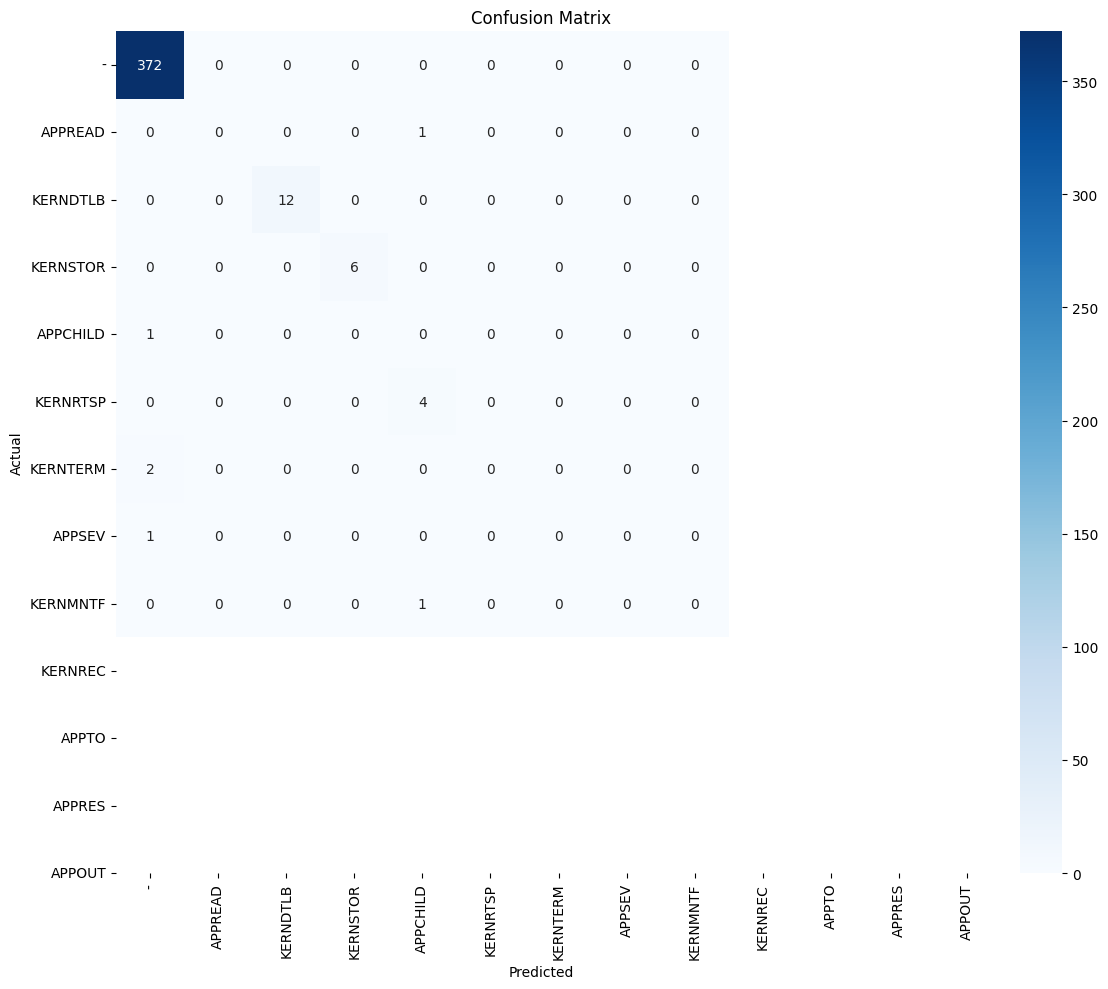

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_actuals, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

## 17. Visualize Training Metrics

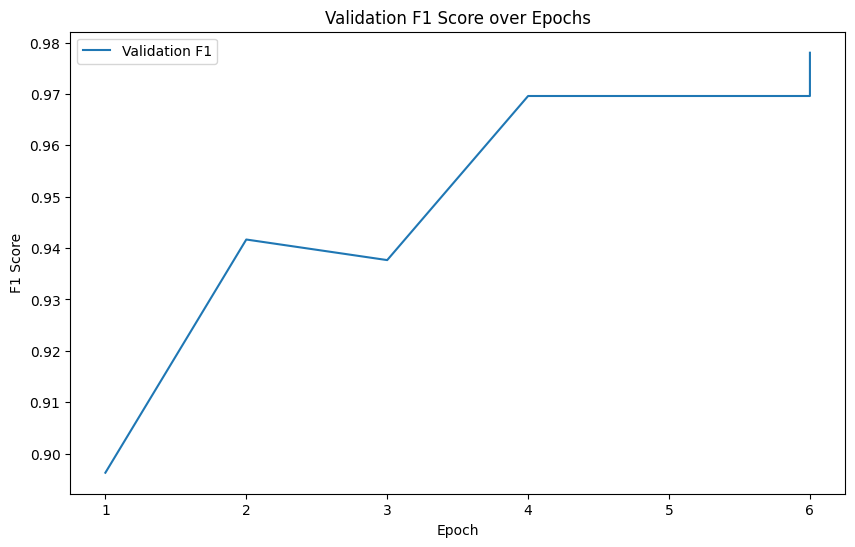

In [ ]:
# Visualize training metrics
logs = trainer.state.log_history
epochs = []
eval_f1 = []

for log in logs:
    if 'epoch' in log and 'eval_f1' in log:
        epochs.append(log['epoch'])
        eval_f1.append(log['eval_f1'])

plt.figure(figsize=(10, 6))
plt.plot(epochs, eval_f1, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score over Epochs')
plt.legend()
plt.savefig('training_metrics.png')
plt.show()

## 18. XAI with SHAP

Explainable AI to understand model predictions and root causes of anomalies.

In [ ]:
# XAI with SHAP
print("\nPerforming SHAP analysis for explainability...")

# Convert sample to inputs
def shap_preprocess(texts, max_samples=50):
    # Take a subset of texts for analysis
    sample_texts = texts[:max_samples]

    # Get original predictions for these texts
    sample_encodings = tokenizer(sample_texts, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors='pt')
    sample_encodings = {k: v.to(device) for k, v in sample_encodings.items()}

    with torch.no_grad():
        outputs = model(**sample_encodings)
        if isinstance(outputs, tuple):
            logits = outputs[1]
        else:
            logits = outputs
        probs = torch.nn.functional.softmax(logits, dim=1)

    # Return both the encodings and predictions
    return sample_encodings, probs, sample_texts

# Take a small sample of logs for analysis
sample_encodings, sample_preds, sample_texts = shap_preprocess(X_test.tolist())


Performing SHAP analysis for explainability...


In [ ]:
# Create a more robust SHAP explainer function
def f(inputs):
    model.eval()

    # Convert inputs to tensors and handle string inputs
    if isinstance(inputs, dict):
        # Dictionary input - keep as is but ensure on right device
        input_dict = {k: v.to(device) if isinstance(v, torch.Tensor) else torch.tensor(v).to(device)
                      for k, v in inputs.items()}
    elif isinstance(inputs, np.ndarray):
        # Check if we have string inputs that need tokenization
        if inputs.dtype.type is np.str_ or inputs.dtype.type is np.object_:
            # We have text inputs, tokenize them
            tokenized = tokenizer(inputs.tolist(), padding='max_length', truncation=True,
                                 max_length=128, return_tensors='pt')
            input_dict = {k: v.to(device) for k, v in tokenized.items()}
        else:
            # We have numeric inputs, convert directly
            input_ids = torch.tensor(inputs).to(device)
            attention_mask = (input_ids != 0).long().to(device)
            input_dict = {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }
    else:
        # Handle other input types (like lists)
        tokenized = tokenizer(inputs, padding='max_length', truncation=True,
                             max_length=128, return_tensors='pt')
        input_dict = {k: v.to(device) for k, v in tokenized.items()}

    # Run the model with the properly formatted inputs
    with torch.no_grad():
        outputs = model(**input_dict)

    # Return the appropriate output
    if isinstance(outputs, tuple):
        return outputs[1].detach().cpu().numpy()
    return outputs.detach().cpu().numpy()

# Initialize the SHAP explainer with the fixed function
explainer = shap.Explainer(f, tokenizer)

SHAP values shape: (2, None, 11)


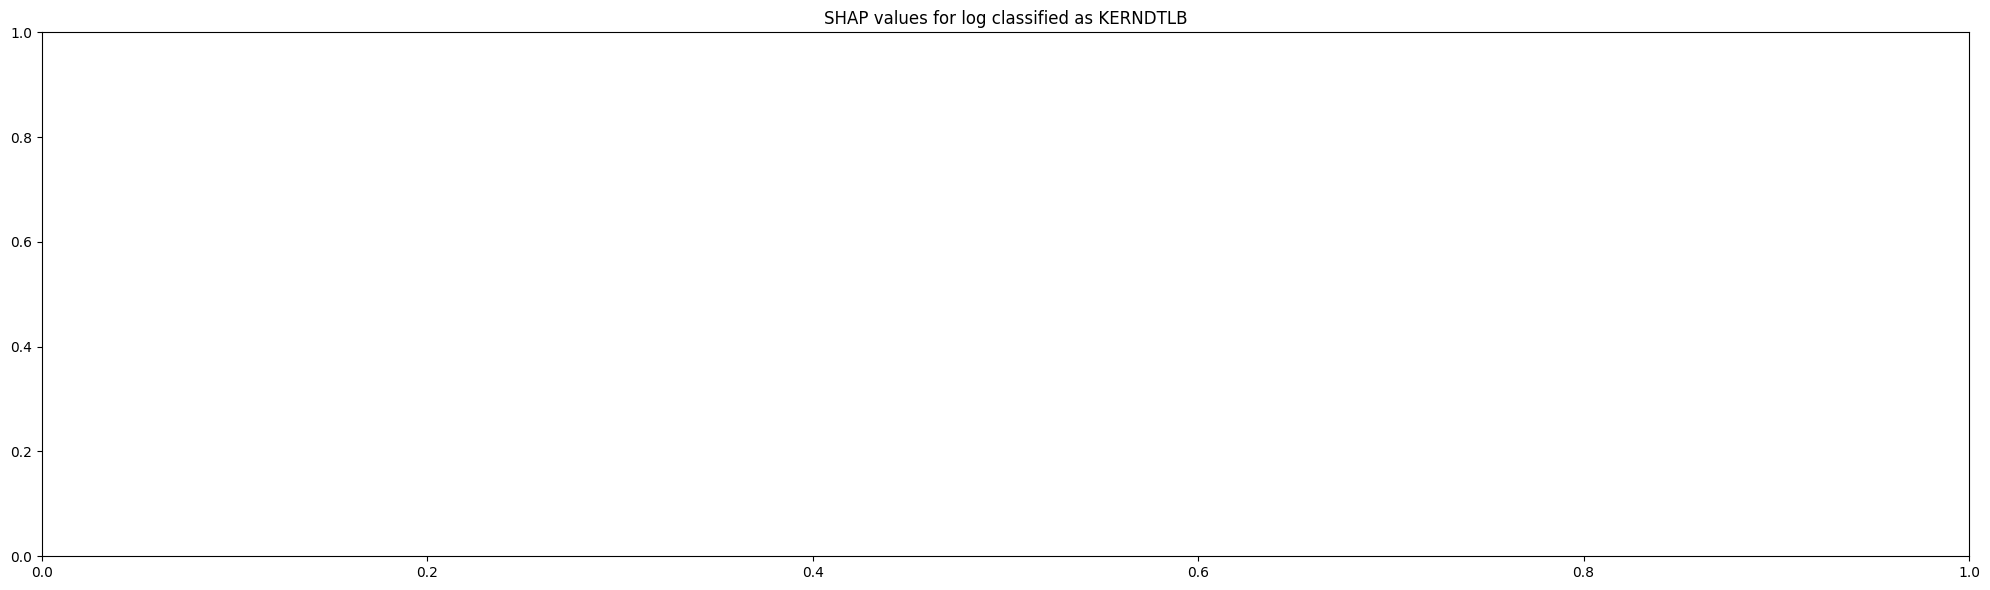

Log: data TLB error interrupt
Predicted as: KERNDTLB
Top contributing tokens:
Error analyzing token contributions: too many indices for array: array is 1-dimensional, but 3 were indexed
Unable to show token contributions


SHAP values shape: (2, None, 11)


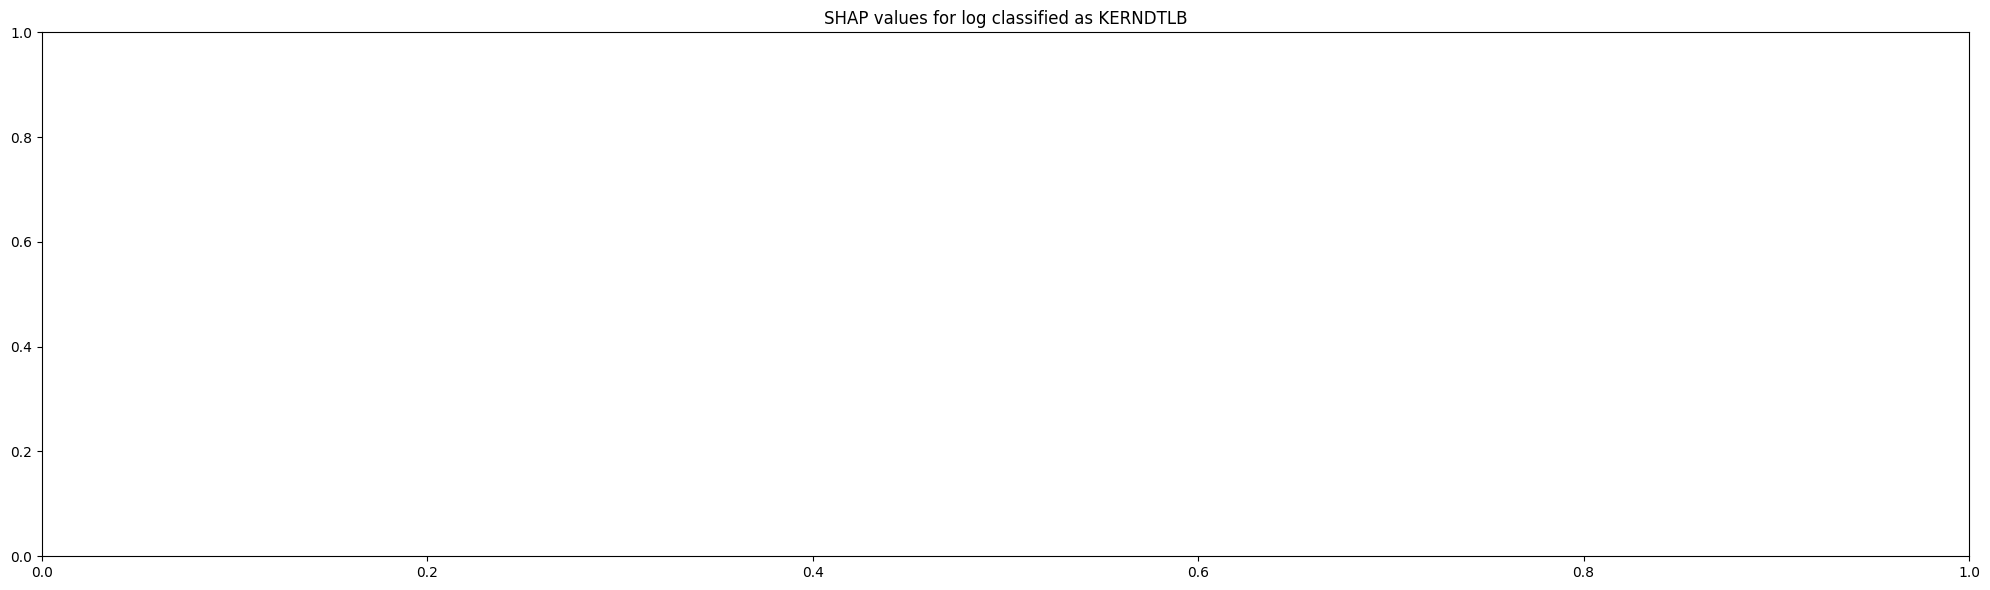

Log: data TLB error interrupt
Predicted as: KERNDTLB
Top contributing tokens:
Error analyzing token contributions: too many indices for array: array is 1-dimensional, but 3 were indexed
Unable to show token contributions




In [ ]:
# Sample a few logs for explanation (first few anomaly logs)
anomaly_indices = [i for i, pred in enumerate(sample_preds.argmax(dim=1).cpu().numpy()) if pred != 0]
anomaly_indices = anomaly_indices[:5]  # Take first 5 anomaly predictions

if anomaly_indices:
    # Extract the anomaly samples
    anomaly_samples = {k: v[anomaly_indices] for k, v in sample_encodings.items()}

    # Get SHAP values
    shap_values = explainer(anomaly_samples)

    # Plot SHAP values for each prediction
    for i, idx in enumerate(anomaly_indices):
        plt.figure(figsize=(20, 6))

        # Get the predicted class
        pred_class = sample_preds[idx].argmax().item()
        pred_label = list(label_map.keys())[pred_class]

        # Get the original text
        original_text = sample_texts[idx]

        # Inspect the structure of shap_values and plot accordingly
        print(f"SHAP values shape: {shap_values.shape}")

        # Different plotting depending on the shape of shap_values
        if hasattr(shap_values, 'values') and hasattr(shap_values, 'data'):
            # Original expected structure
            try:
                shap.plots.text(shap_values[i, :, pred_class])
            except:
                print("Error with standard plotting, trying alternative format")
                shap.plots.text(shap_values)
        else:
            # Alternative structure
            try:
                # Try different ways to visualize based on the structure
                if hasattr(shap_values, 'shape') and len(shap_values.shape) >= 3:
                    # If it's a 3D array
                    shap.plots.text(shap_values[i, :, pred_class])
                elif hasattr(shap_values, 'shape') and len(shap_values.shape) == 2:
                    # If it's a 2D array
                    shap.plots.text(shap_values[i])
                else:
                    # Fallback
                    shap.plots.text(shap_values)
            except Exception as e:
                print(f"Error plotting SHAP values: {e}")
                print("Skipping visualization but continuing with analysis")

        plt.title(f"SHAP values for log classified as {pred_label}")
        plt.tight_layout()
        plt.savefig(f'shap_explanation_{i}.png')
        plt.show()

        # Print original text and explanation
        print(f"Log: {original_text}")
        print(f"Predicted as: {pred_label}")

        # Display token contributions based on the structure of shap_values
        print("Top contributing tokens:")
        try:
            if hasattr(shap_values, 'values') and hasattr(shap_values, 'data'):
                token_scores = list(zip(shap_values.data[i], shap_values.values[i, :, pred_class]))
            elif hasattr(shap_values, 'base_values'):
                # For newer SHAP versions
                tokens = tokenizer.encode(original_text, truncation=True, max_length=128)
                token_scores = [(token, score) for token, score in zip(tokens, shap_values[i].values)]
            else:
                # Generic fallback
                tokens = tokenizer.encode(original_text, truncation=True, max_length=128)
                scores = shap_values[i] if len(shap_values.shape) == 2 else shap_values[i, :, pred_class]
                token_scores = list(zip(tokens, scores))

            sorted_tokens = sorted(token_scores, key=lambda x: abs(x[1]) if isinstance(x[1], (int, float)) else 0, reverse=True)

            # Display contributing tokens and their scores
            for token_id, score in sorted_tokens[:10]:
                if token_id != 0:  # Skip padding token
                    token = tokenizer.decode([token_id])
                    if isinstance(score, (int, float)):
                        print(f"  {token}: {score:.4f}")
                    else:
                        print(f"  {token}: {score}")
        except Exception as e:
            print(f"Error analyzing token contributions: {e}")
            print("Unable to show token contributions")

        print("\n")
else:
    print("No anomalies found in the sample for SHAP analysis.")

## 19. Final Summary and Save Model

In [ ]:
# Final summary
print("\nFinal Model Summary:")
print(f"Number of classes: {num_classes}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Log final metrics to WandB
wandb.log({
    "final_accuracy": accuracy,
    "final_f1": f1,
    "final_precision": precision,
    "final_recall": recall
})

# Save the model
model.save_pretrained('./log_anomaly_model')
tokenizer.save_pretrained('./log_anomaly_model')
print("\nModel saved to './log_anomaly_model'")

# Finish WandB run
wandb.finish()


Final Model Summary:
Number of classes: 13
Test Accuracy: 0.9750
Test F1 Score: 0.9700

Model saved to './log_anomaly_model'


eval/accuracy,▅▁▅▄▇▇▇█
eval/f1,▅▁▅▅▇▇▇█
eval/loss,▇█▆▄▂▂▁▂
eval/precision,▅▁▅▅▇▇▇█
eval/recall,▅▁▅▄▇▇▇█
eval/runtime,█▄▃▇▄▄▁▇
eval/samples_per_second,▁▅▅▂▄▅█▂
eval/steps_per_second,▁▅▅▂▄▅█▂
final_accuracy,▁
final_f1,▁
final_precision,▁


In [ ]:
 # Final Model Validation with Sample Logs
print("\n## LogLite Model Validation with Sample Logs ##\n")

# Define some sample logs to test
sample_logs = [
    "instruction cache parity error corrected",  # Normal
    "data TLB error interrupt",  # KERNDTLB (anomaly)
    "Lustre mount FAILED",  # KERNMNTF (anomaly)
    "process ended abnormally",  # Normal
    "I/O nodes per ND: 2, 4",  # Normal
    "application terminated with error status 1",  # APPTERM (anomaly)
    "read failed due to storage error",  # KERNSTOR (anomaly)
    "execution terminated due to signal 9",  # KERNTERM (anomaly)
]

# Tokenize sample logs
sample_encodings = tokenizer(
    sample_logs,
    padding='max_length',
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

# Move inputs to the same device as the model
sample_encodings = {k: v.to(device) for k, v in sample_encodings.items()}

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(**sample_encodings)

    # Handle outputs correctly - check if it's a tuple or a tensor
    if isinstance(outputs, tuple):
        logits = outputs[0]  # First item is usually the logits
    else:
        logits = outputs  # The outputs are directly the logits tensor

    # For multi-class classification
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    predictions = torch.argmax(probabilities, dim=1)

# Define root cause explanations for different anomaly types
root_cause_explanations = {
    "KERNDTLB": "Memory addressing issue. The Translation Lookaside Buffer (TLB) is experiencing errors, indicating potential memory management problems or hardware issues with the memory management unit.",

    "KERNSTOR": "Storage subsystem failure. There may be disk I/O errors, corrupt filesystem, or hardware failures in the storage system.",

    "KERNRTSP": "Runtime process issues. The kernel detected issues with runtime scheduling or process management.",

    "KERNTERM": "Kernel process termination. A critical system process was terminated unexpectedly, possibly due to a crash or resource exhaustion.",

    "APPSEV": "Severe application error. The application encountered a critical error that it couldn't recover from.",

    "KERNMNTF": "Mount failure. The system failed to mount a filesystem, indicating potential connectivity, permission, or filesystem corruption issues.",

    "APPTO": "Application timeout. The application failed to respond within the expected time frame, suggesting deadlocks or resource constraints.",

    "APPRES": "Resource exhaustion. The application ran out of necessary resources (memory, file handles, etc.).",

    "APPREAD": "Read operation failed. The application couldn't read required data, potentially due to permissions or data corruption.",

    "APPOUT": "Output error. The application encountered an error while writing output data."
}

# Display results with explanations
print("Sample Log Analysis:\n")
for i, log in enumerate(sample_logs):
    pred_idx = predictions[i].item()
    pred_class = list(label_map.keys())[pred_idx]

    # Get top 2 classes and their probabilities for more nuanced analysis
    top_probs, top_indices = torch.topk(probabilities[i], 2)
    top_classes = [list(label_map.keys())[idx.item()] for idx in top_indices]
    top_probs = top_probs.cpu().numpy()

    # Determine if it's normal or anomaly
    is_normal = pred_class == '-'

    print(f"Log: {log}")
    print(f"Prediction: {'NORMAL' if is_normal else 'ANOMALY'} ({pred_class}) with {top_probs[0]*100:.2f}% confidence")

    if not is_normal:
        print(f"Top classifications: {top_classes[0]} ({top_probs[0]*100:.2f}%), {top_classes[1]} ({top_probs[1]*100:.2f}%)")
        print(f"Potential root cause: {root_cause_explanations.get(pred_class, 'Unknown cause')}")

        # Extract key indicators from the log
        key_terms = []
        for term in ["error", "fail", "terminate", "abort", "corrupt", "timeout", "interrupt", "crash", "denied", "invalid"]:
            if term.lower() in log.lower():
                key_terms.append(term)

        if key_terms:
            print(f"Key indicators: {', '.join(key_terms)}")

    # Analyze log content for additional context
    log_words = log.lower().split()
    component_terms = {
        "memory": ["memory", "cache", "tlb", "buffer", "heap", "allocation"],
        "storage": ["disk", "storage", "file", "i/o", "read", "write"],
        "network": ["network", "connection", "socket", "communication"],
        "process": ["process", "thread", "execution", "terminated"],
        "resource": ["resource", "limit", "exhausted", "capacity"]
    }

    affected_components = []
    for component, terms in component_terms.items():
        if any(term in log_words for term in terms):
            affected_components.append(component)

    if affected_components:
        print(f"Affected components: {', '.join(affected_components)}")

    print("Recommended action:", end=" ")
    if is_normal:
        print("No action needed - log indicates normal operation.")
    else:
        if "memory" in affected_components:
            print("Check system memory usage and hardware health. Consider memory diagnostics.")
        elif "storage" in affected_components:
            print("Verify disk health, filesystem integrity, and storage connectivity.")
        elif "network" in affected_components:
            print("Examine network configuration and connectivity.")
        elif "process" in affected_components:
            print("Review application logs for specific errors and monitor system resources.")
        else:
            print("Investigate system logs for related issues and check component status.")

    print("\n" + "-"*80 + "\n")

# Overall system health assessment
anomaly_percentage = (len([p for p in predictions if p != 0]) / len(predictions)) * 100
print(f"System Health Assessment: {100-anomaly_percentage:.1f}% healthy")
if anomaly_percentage > 50:
    print("CRITICAL: Multiple system components showing failures. Immediate investigation required.")
elif anomaly_percentage > 20:
    print("WARNING: System showing signs of instability. Monitoring and preventive action recommended.")
else:
    print("STABLE: System operating within normal parameters. Routine monitoring advised.")


## LogLite Model Validation with Sample Logs ##

Sample Log Analysis:

Log: instruction cache parity error corrected
Prediction: NORMAL (-) with 92.03% confidence
Affected components: memory
Recommended action: No action needed - log indicates normal operation.

--------------------------------------------------------------------------------

Log: data TLB error interrupt
Prediction: ANOMALY (KERNDTLB) with 53.90% confidence
Top classifications: KERNDTLB (53.90%), KERNSTOR (11.12%)
Potential root cause: Memory addressing issue. The Translation Lookaside Buffer (TLB) is experiencing errors, indicating potential memory management problems or hardware issues with the memory management unit.
Key indicators: error, interrupt
Affected components: memory
Recommended action: Check system memory usage and hardware health. Consider memory diagnostics.

--------------------------------------------------------------------------------

Log: Lustre mount FAILED
Prediction: NORMAL (-) with 28.02% co

In [ ]:
   !zip -r model.zip ./log_anomaly_model/

  adding: log_anomaly_model/ (stored 0%)
  adding: log_anomaly_model/model.safetensors (deflated 8%)
  adding: log_anomaly_model/vocab.txt (deflated 53%)
  adding: log_anomaly_model/tokenizer_config.json (deflated 75%)
  adding: log_anomaly_model/config.json (deflated 56%)
  adding: log_anomaly_model/tokenizer.json (deflated 71%)
  adding: log_anomaly_model/special_tokens_map.json (deflated 42%)


In [ ]:
   from google.colab import drive
   drive.mount('/content/drive')
   !cp -r ./log_anomaly_model/ /content/drive/MyDrive/

Mounted at /content/drive
